In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

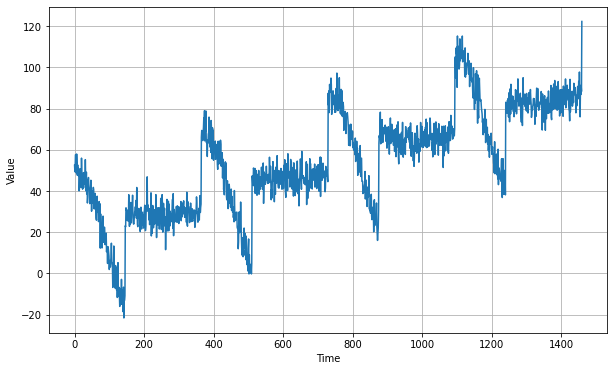

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [ ]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

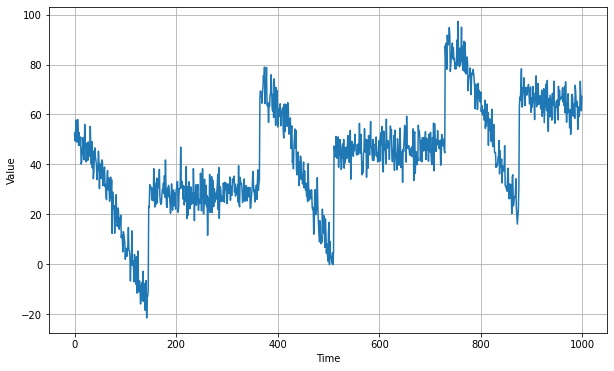

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

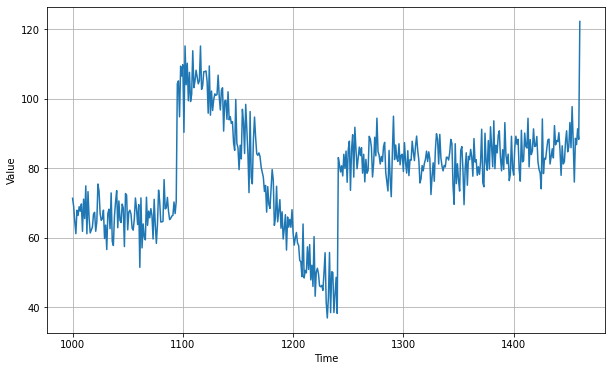

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

model = tf.keras.models.Sequential([l0])

print(f'weights: {l0.get_weights()}')

model.summary()

weights: [array([[-0.45939642],
       [ 0.39399457],
       [ 0.3732878 ],
       [ 0.00390679],
       [ 0.02377206],
       [-0.29043138],
       [-0.5069132 ],
       [-0.04602525],
       [-0.06646574],
       [ 0.47263783],
       [-0.27152017],
       [ 0.4819302 ],
       [ 0.35121864],
       [ 0.33018696],
       [ 0.44587117],
       [ 0.50340587],
       [ 0.04705435],
       [ 0.3044346 ],
       [ 0.02482748],
       [ 0.01363403]], dtype=float32), array([0.], dtype=float32)]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [ ]:
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 652.6809
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 162.2305
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 136.4324
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 122.9543
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 117.1375
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 111.4927
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 106.3910
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 103.4680
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 98.2515
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 94.5253
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 91.8879
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 89.6837
Epoch 13/100
31/

In [ ]:
print(f'weights: {l0.get_weights()}')

weights: [array([[-1.24156155e-01],
       [ 6.27439395e-02],
       [ 7.49171004e-02],
       [ 1.77849986e-04],
       [ 2.33752634e-02],
       [ 5.09798992e-03],
       [-8.23438838e-02],
       [ 4.17615660e-02],
       [-3.12709548e-02],
       [ 1.02090426e-01],
       [-1.10338889e-01],
       [ 5.36062978e-02],
       [-4.45390120e-02],
       [ 4.40749750e-02],
       [ 9.55290161e-03],
       [ 9.58981365e-02],
       [-8.70840810e-03],
       [ 2.02503145e-01],
       [ 2.55240738e-01],
       [ 4.37370747e-01]], dtype=float32), array([0.01512581], dtype=float32)]


In [ ]:
print(f'shape: {series[0:20].shape}')

print(f'new shape: {series[0:20][np.newaxis].shape}')

print(f'new shape alt: {np.expand_dims(series[0:20], axis=0).shape}')

shape: (20,)
new shape: (1, 20)
new shape alt: (1, 20)


In [ ]:
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

model prediction: [[44.511536]]


In [ ]:
forecast = []

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]

print(f'len of forecast: {len(forecast)}')
print(f'x_valid shape: {x_valid.shape}')

len of forecast: 461
x_valid shape: (461,)


shape: (461, 1, 1)
shape squeeze: (461,)


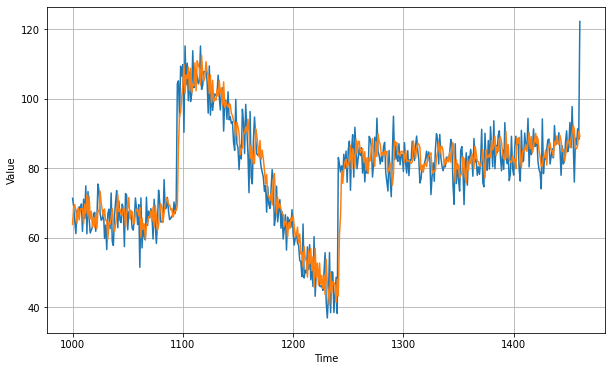

In [ ]:
print(f'shape: {np.array(forecast).shape}')
print(f'shape squeeze: {np.array(forecast).squeeze().shape}')

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid,results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid,results).numpy())

5.1534796
47.19825
